In [1]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
infile = open("Modelling_dataset_train.pickle",'rb')
train = pickle.load(infile)
infile.close()

infile1 = open("Modelling_dataset_test.pickle",'rb')
test = pickle.load(infile1)
infile1.close()

In [3]:
train.head()

,Class Index,Title,Description,Content_Parsed
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",reuters shortsellers wall street dwindle band ...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,reuters private investment firm carlyle group ...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,reuters soar crude price plus worry economy ou...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,reuters authorities halt oil export flow main ...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",afp tearaway world oil price topple record str...


In [4]:
test.head()

,Class Index,Title,Description,Content_Parsed
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...,unions represent workers turner newall say 'di...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o...",spacecom toronto canada second team rocketeers...
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...,ap company found chemistry researcher universi...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...,ap barely dawn mike fitzpatrick start shift bl...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...,ap southern california smogfighting agency go ...


# Data Splitting

In [5]:
Xtrain = train["Content_Parsed"]
Ytrain = train["Class Index"]
Xtest = test["Content_Parsed"]
Ytest = test["Class Index"]

In [6]:
np.random.seed(42)

# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(Xtrain,
                                                    Ytrain,
                                                    test_size=0.9)

# Text Representations

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
features_train = tfidf.fit_transform(X_train)
labels_train = y_train

features_test = tfidf.transform(X_test)
labels_test = y_test


# Hyperparameter Tuning

### Using RandomizedSearch CV

In [8]:
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
# define grid search
knn_grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)

In [9]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifier
rs_knn = RandomizedSearchCV(KNeighborsClassifier(), 
                           param_distributions=knn_grid,
                           cv=3,
                           n_iter=20,
                           verbose=True)

In [10]:
rs_knn.fit(features_train, labels_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.5min finished


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=20,
                   param_distributions={'metric': ['euclidean', 'manhattan',
                                                   'minkowski'],
                                        'n_neighbors': range(1, 21, 2),
                                        'weights': ['uniform', 'distance']},
                   verbose=True)

In [11]:
rs_knn.best_params_

{'weights': 'distance', 'n_neighbors': 17, 'metric': 'minkowski'}

In [12]:
rs_knn.score(features_test, labels_test)

0.8734444444444445

In [13]:
rs_knn.score(features_train, labels_train)

0.9993333333333333

### Using GridSearch CV

In [20]:
np.random.seed(42)
# Create a list of differnt values for n_neighbors
neighbors = range(12, 20)
weights = ['distance']
metric = ['minkowski']
# define grid search
knn_grid1 = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
# Setup KNN instance
knn2 = KNeighborsClassifier()
# Use GridSearch
clf=GridSearchCV(knn2, knn_grid1)
# Fit the model
clf.fit(features_train, labels_train)


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski'],
                         'n_neighbors': range(1, 21, 2),
                         'weights': ['distance']})

In [21]:
clf.score(features_train, labels_train)

0.9993333333333333

In [22]:
clf.score(features_test, labels_test)

0.872462962962963

# Evaluating our machine learing model beyond accuracy

In [23]:
y_preds = clf.predict(features_test)
y_preds

array([3, 3, 2, ..., 2, 2, 1], dtype=int64)

In [24]:
np.array(y_test)

array([3, 3, 2, ..., 2, 2, 1], dtype=int64)

### Confusion Matrix

In [25]:
# Confusion matrix
confusion_matrix(y_test, y_preds)

array([[23617,  1020,  1643,   723],
       [  495, 25915,   348,   258],
       [ 1126,   454, 22887,  2459],
       [ 1539,   703,  3006, 21807]], dtype=int64)

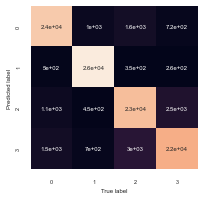

In [28]:
sns.set(font_scale=0.5)

def plot_conf_mat(y_test, y_preds):
    """
    Plots a nice looking confusion matrix using Seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
    
plot_conf_mat(y_test, y_preds)

In [29]:
pd.crosstab(y_test, y_preds, rownames=["Actual Labels"], colnames=["Predicted Labels"])

Predicted Labels,1,2,3,4
Actual Labels,,,,
1,23617,1020,1643,723
2,495,25915,348,258
3,1126,454,22887,2459
4,1539,703,3006,21807


### Classification Report

In [30]:
# classification report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           1       0.88      0.87      0.88     27003
           2       0.92      0.96      0.94     27016
           3       0.82      0.85      0.84     26926
           4       0.86      0.81      0.83     27055

    accuracy                           0.87    108000
   macro avg       0.87      0.87      0.87    108000
weighted avg       0.87      0.87      0.87    108000

